

**THIS IS NOT THE COMPLETE TUTORIAL - see file with (MAIN) in the name. Paste all this code before the first Python block**

First you'll need to select which hardware setup you have. You'll need to select both a `SCOPETYPE` and a `PLATFORM`. `SCOPETYPE` can either be `'OPENADC'` for the CWLite/CW1200 or `'CWNANO'` for the CWNano. `PLATFORM` is the target device, with `'CWLITEARM'`/`'CW308_STM32F3'` being the best supported option, followed by `'CWLITEXMEGA'`/`'CW308_XMEGA'`, then by `'CWNANO'`. As of CW 5.4, you can select the SimpleSerial version
used. For example:

```python
SCOPETYPE = 'OPENADC'
PLATFORM = 'CWLITEARM'
SS_VER = 'SS_VER_2_1'
```

In [1]:
SCOPETYPE = 'OPENADC'
PLATFORM = 'CWLITEARM'
SS_VER = 'SS_VER_2_1'
#import os
#os.chdir('C:/Users/prith/ChipWhisperer5_64/cw/home/portable/chipwhisperer/jupyter/courses/sca101')

This code will connect the scope and do some basic setup. We're now just going to use a special setup script to do this. This script contains the commands we ran seperately before.

In [2]:
%run "../../Setup_Scripts/Setup_Generic.ipynb"

INFO: Found ChipWhisperer😍


The following code will build the firmware for the target.

In [ ]:
import os
os.chdir('../../../hardware/victims/firmware/basic-NN')
print(os.listdir())
!make PLATFORM=CWLITEARM CRYPTO_TARGET=NONE SS_VER=SS_VER_2_1

['.comm_check.c.swp', '.dep', '.ipynb_checkpoints', 'basic-NN-CWLITEARM.bin', 'basic-NN-CWLITEARM.eep', 'basic-NN-CWLITEARM.elf', 'basic-NN-CWLITEARM.hex', 'basic-NN-CWLITEARM.lss', 'basic-NN-CWLITEARM.map', 'basic-NN-CWLITEARM.sym', 'basic-NN.c', 'comm_check.c', 'makefile', 'Makefile.inc', 'modified_mnist_test.csv', 'objdir-CWLITEARM']


Finally, all that's left is to program the device, which can be done with the following line:

In [35]:
cw.program_target(scope, prog, "basic-NN-{}.hex".format(PLATFORM))

Detected known STMF32: STM32F302xB(C)/303xB(C)
Extended erase (0x44), this can take ten seconds or more
Attempting to program 4563 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 4563 bytes


To make interacting with the hardware easier, let's define a function to attempt a password and return a power trace:

In [53]:
# def cap_pass_trace(pass_guess):
#     reset_target(scope)
#     num_char = target.in_waiting()
#     while num_char > 0:
#         target.read(num_char, 10)
#         time.sleep(0.01)
#         num_char = target.in_waiting()

#     scope.arm()
#     target.write(pass_guess)
#     ret = scope.capture()
#     if ret:
#         print('Timeout happened during acquisition')

#     trace = scope.get_last_trace()
#     return trace

We also don't need all of the default 5000 samples in the trace. 3000 is a good starting point for most targets:

In [43]:
scope.adc.samples = 5000

In [8]:
f = open("modified_mnist_test.csv",'r')

c= 0
label = []
features_string = []
for line in f :
    if c >=1 :# and c<10 :
        features_label = line.split(",")
#        print(features)
        l = len(features_label)
        label.append(features_label[l-1].replace("\n",""))
        f_s = ""
        for i in range(0,l-1):
            f_s = f_s + features_label[i]
        features_string.append(f_s)
    c = c+ 1
    
print(features_string[1])
print(label[1])

0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000111111000000000000000000000111111110000000000000000000111111111100000000000000000011100001110000000000000000001100001110000000000000000000000000111000000000000000000000000111100000000000000000000000011100000000000000000000000011110000000000000000000000011110000000000000000000000001110000000000000000000000001111000000000000000000000000111000000000000000000000000111100000000000000000000000111100000000000000000000000011100000000000000000000000001110000000000011110000000000111111111111111111100000000011111111111111111100000000000111111111110000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
2


In [28]:
# scope.dis()
# target.dis()
#
# DEFINE THE cap_pass_trace() function - either using a hardware connection or the file read-out.
#
def cap_pass_trace(pass_guess):
    reset_target(scope)
    num_char = target.in_waiting()
    m = ""
    while num_char > 0:
        m = target.read(num_char, 10)
        time.sleep(0.1)
        num_char = target.in_waiting()
        #print(m)
    
#     print(target.read)
    scope.arm()
    target.write(pass_guess)
    ret = scope.capture()
    if ret:
        print('Timeout happened during acquisition')

    trace = scope.get_last_trace()
    return trace, m

#raise NotImplementedError("Add your code here, and delete this.")

trace_test,m = cap_pass_trace(features_string[1]+"\n")

print(m)
#Basic sanity check
assert(len(trace_test) == 5000)
print("✔️ OK to continue!")

Received data: 000000000
Sending data back to PC: 000000000
Waiting for data from PC...
 Waiting for data from PC...

✔️ OK to continue!


#### Communication Check

In [46]:
def cap_pass_trace(pass_guess):
    reset_target(scope)
    scope.arm()
    target.write(pass_guess)
    time.sleep(1)
    target.write(pass_guess[1:])
    time.sleep(1)
    num_char = target.in_waiting()
    m = ""
    while num_char > 0:
        m = target.read(num_char, 10)
        time.sleep(0.1)
        num_char = target.in_waiting()
        #print(m)
    
#     print(target.read)
   
    ret = scope.capture()
    if ret:
        print('Timeout happened during acquisition')

    trace = scope.get_last_trace()
    return trace, m

#raise NotImplementedError("Add your code here, and delete this.")
trace_test,m = cap_pass_trace("SHelloWorld"+"\n")

print(m)
print("✔️ OK to continue!")

 Waiting for 'S' command...
Received 'S' command. Waiting for data...
Received data: HHelloWor
Sending data back to PC: HHelloWor

✔️ OK to continue!


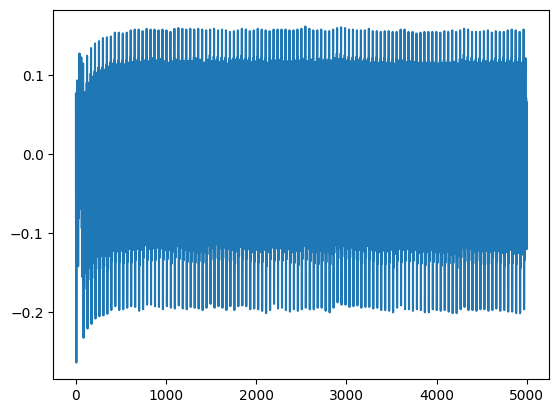

In [55]:
import matplotlib.pyplot as plt
plt.plot(trace_test);

In [47]:
trace_list = []
pred_list = []
print(len(label))
for i in range(0,100) :
    print(i)
    trace_h,m = cap_pass_trace(features_string[i]+"\n")
    time.sleep(2)
    trace_list.append(trace_h)
    pred_list.append(m)

print(pred_list)
# print(features_label[0:11])
    

10000
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
['2\x83\x0e\xad\x00', '7\x83\x0e\xadâ@*ÀóíeÁátº¿¬®q@Ñ\x1b¹À\x93¬ó¿\x07º4Á7g\x13A¿\x9dÄ¿2\x8cô?00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', '2\x83\x0e\xad\x00', '1\x83\x0e\xadSDÕÀ\x81\x9a¤@7l_?ä\x0f\x8c¿wDNÀ\r\x15\x1aÀ¼\x8dÃ¿\x9d~Ö¿\x86@7>^º3À00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000011000000000000000000000000', '0\x83\x0e\xad\xad\x05\x0eA>ÿ{ÁAà\x97¿*Ï$À<8\x16Áñ"9¿È{É¿öa\x11Àâ\x19\x0eÀY@ À00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

In [48]:
pred_list[0][0]
l = len(pred_list)
c = 0
for i in range(1,len(pred_list)) :
    if pred_list[i][0] == label[i-1] :
        c = c+1
print(f"Accuracy {float(c/l)}")

Accuracy 0.96


In [49]:
all_sum = {}
all_sum[0] = []
all_sum[1] = []
all_sum[2] = []
all_sum[3] = []
all_sum[4] = []
all_sum[5] = []
all_sum[6] = []
all_sum[7] = []
all_sum[8] = []
all_sum[9] = []

nos_of_0 = 0
avg_0 = []
for i in range(0,len(pred_list)) :
    all_sum[int(pred_list[i][0])].append(trace_list[i])

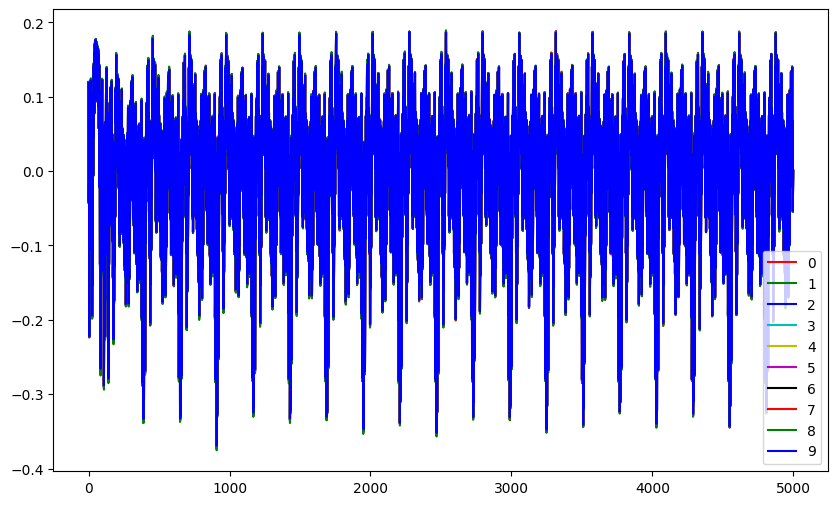

In [50]:
import matplotlib.pyplot as plt
from ipywidgets import interact

color=['r','g','b','c','y','m','k','r','g','b']
plt.figure(figsize=(10,6))
for i in range(10):
    plt.plot(np.mean(np.array(all_sum[i]), axis=0), label = i, c=color[i])

plt.legend()
plt.show()

In [52]:
Average_across_samples = {}
for i in range(10):
    Average_across_samples[i] = np.mean(np.array(all_sum[i]))
print('Average power: ',Average_across_samples)

# Sorting the dictionary by values
sorted_dict = dict(sorted(Average_across_samples.items(), key=lambda item: abs(item[1])))

print("Sorted average power:", sorted_dict)

Average power:  {0: -0.007844118923611112, 1: -0.007917159598214285, 2: -0.007878076171875, 3: -0.00789189453125, 4: -0.007877749399038462, 5: -0.007936100260416667, 6: -0.007873845880681818, 7: -0.00793125, 8: -0.00793935546875, 9: -0.00785775390625}
Sorted average power: {0: -0.007844118923611112, 9: -0.00785775390625, 6: -0.007873845880681818, 4: -0.007877749399038462, 2: -0.007878076171875, 3: -0.00789189453125, 1: -0.007917159598214285, 7: -0.00793125, 5: -0.007936100260416667, 8: -0.00793935546875}
